# Imports

In [6]:
import os
import json
import pickle
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from utils import *

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [8]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [9]:
# define a function to visualize the PCA elbow plot
def evaluate_pca(pca):
    
    # compute the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # plot the elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative % of Variation Explained')
    plt.title('Principal Component Elbow Plot')
    plt.grid(True)
    
    # find the location of inflection point
    # NOTE: this is used to determine the best number of PC's
    diff = np.diff(cumulative_variance)
    inflection_point = np.argmax(diff < np.mean(diff))
    plt.axvline(x=inflection_point + 1, color='r', linestyle='--')
    plt.axhline(y=cumulative_variance[inflection_point], color='r', linestyle='--')
    
    # add label to indicate inflection point
    plt.text(inflection_point + 50, cumulative_variance[inflection_point] - .2,
            f"n_components={inflection_point + 1}\ncum_%_variation={cumulative_variance[inflection_point]*100:.2f}%", color='r', fontsize=10)

    plt.show()
    
    return inflection_point + 1
    

In [10]:
# define a function to display the main features that contribute to a set of top PC's
def display_loadings(pca, n_pc=5, n_features=10):
    
    # extract top principal components
    top_components = pca.components_[:n_pc]

    # create dataframes for top principal components
    for i, component in enumerate(top_components):
        loading_scores = pd.DataFrame({'feature_name': feature_names, 'loading_score': component})
        loading_scores = loading_scores.sort_values(by='loading_score', ascending=False).head(n_features)
        print(f"Top {n_features} features for Principal Component {i + 1}:")
        display(loading_scores)

# Load data

In [11]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [12]:
# load feature data from disk
feature_vectors, feature_names = load_feature_data("../data/processed/feature_vectors_2.tar.gz", "../data/processed/feature_names_2.pkl")

In [13]:
# inspections
print(type(feature_vectors))
print(feature_vectors.keys())
print(type(feature_vectors['beach']))
print(len(feature_vectors['beach']))
print(type(feature_vectors['beach'][0]))
print(len(feature_vectors['beach'][0]))
print(feature_vectors['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
<class 'numpy.ndarray'>
1367
[1.13955765e+02 1.27463531e+02 1.19847519e+02 ... 2.08073282e-01
 3.18124076e-02 8.04467964e-01]


# Principal Component Analysis

In [14]:
# flatten feature vectors and prepare data for PCA
X = []
for class_name in classes:
    X.extend(feature_vectors[class_name])
X = np.array(X)

# perform PCA
pca_model = PCA()
pca_model.fit(X)

PCA()

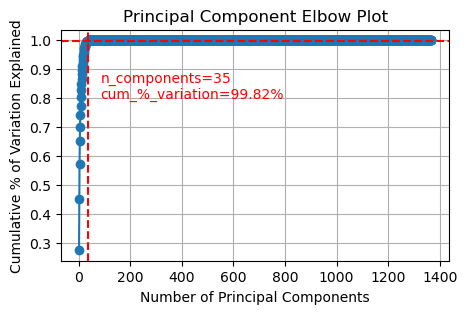

In [15]:
n_pc_components = evaluate_pca(pca_model)

In [16]:
display_loadings(pca_model, n_pc=5, n_features=5)

Top 5 features for Principal Component 1:


,feature_name,loading_score
14,h_9,0.811166
59,v_14,0.146916
32,s_7,0.139948
31,s_6,0.137426
58,v_13,0.100367


Top 5 features for Principal Component 2:


,feature_name,loading_score
13,h_8,0.382852
27,s_2,0.337870
28,s_3,0.289629
14,h_9,0.252270
54,v_9,0.217074


Top 5 features for Principal Component 3:


,feature_name,loading_score
13,h_8,0.704412
30,s_5,0.265843
31,s_6,0.234171
29,s_4,0.160002
49,v_4,0.079103


Top 5 features for Principal Component 4:


,feature_name,loading_score
8,h_3,0.320865
26,s_1,0.293695
27,s_2,0.204464
6,h_1,0.195542
9,h_4,0.190376


Top 5 features for Principal Component 5:


,feature_name,loading_score
51,v_6,0.452383
26,s_1,0.338953
52,v_7,0.289136
6,h_1,0.206872
12,h_7,0.165014


In [17]:
# re-compute pca model with optimum number of PC's
pca_model = PCA(n_components=n_pc_components)
pca_model.fit(X)

# save the pca model to disk
with open("../data/processed/pca_model.pkl", 'wb') as f:
    pickle.dump(pca_model, f)